In [2]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

[nltk_data] Downloading package stopwords to /Users/geko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/geko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# read processed data
data = pd.read_csv('./imdb_processed.csv')
print(data.head())
data = data.iloc[np.random.permutation(len(data))]
print(data.head())

                                                text  label
0  i rented i am curious yellow video store contr...      0
1  i am curious yellow risible pretentious steami...      0
2  if avoid making type film future this film int...      0
3  this film probably inspired godard masculin fé...      0
4  oh brother hearing ridiculous film umpteen yea...      0
                                                    text  label
2488   what poor excuse new zealnd movie making i ash...      0
28357  a hyped slick edgy reinterpretation they falle...      0
5952   written excellent mcgovern directed frears fil...      0
30808  i slouch finding redeeming social value whatev...      0
5452   a typical goth chick rainbow harvest looking l...      0


In [4]:
# get all processed reviews
reviews = data.text.values
# merge into single variable, separated by whitespaces
words = ' '.join(reviews)
# obtain list of words
words = words.split()

# check our list
words[:10]

['what',
 'poor',
 'excuse',
 'new',
 'zealnd',
 'movie',
 'making',
 'i',
 'ashamed',
 'call']

In [5]:
# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

In [6]:
# encode words
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# print first-10 words of first 5 reviews
for i in range(5):
  print(reviews_enc[i][:10])

100%|██████████| 50000/50000 [00:00<00:00, 65319.34it/s]

[107, 242, 1301, 82, 51024, 3, 140, 1, 2948, 561]
[39, 5898, 4190, 4811, 44301, 110, 2963, 594, 5898, 4190]
[317, 229, 16190, 436, 39762, 4, 3077, 1339, 7, 374]
[1, 26900, 1380, 1661, 1010, 1008, 770, 177, 4, 20]
[39, 696, 8837, 2053, 6670, 8163, 165, 6, 1539, 19061]


In [7]:
# the length of the reviews is often different
# we have to define a meximum seqeunce length and add padding tokens
# or trim the text

# padding sequences

def pad_features(reviews, pad_id, seq_length=128):
  # features = np.zeros((len(reviews), seq_length), dtype=int)
  features = np.full((len(reviews), seq_length), pad_id, dtype=int)

  for i, row in enumerate(reviews):
    # if seq_length < len(row) then review will be trimmed
    features[i, :len(row)] = np.array(row)[:seq_length]

  return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

In [8]:
# get labels as numpy
labels = data.label.to_numpy()

In [9]:
# divide the dataset in train and test
# then we divide again in train and validation

train_size = 0.8
validation_size = 0.5

split_id = int(len(features) * train_size)

temp_train_x, test_x = features[:split_id], features[split_id:]
temp_train_y, test_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(temp_train_x) * validation_size)
train_x, val_x = temp_train_x[:split_val_id], temp_train_x[split_val_id:]
train_y, val_y = temp_train_y[:split_val_id], temp_train_y[split_val_id:]

# now we have train, val and test
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

print(train_x)

Feature Shapes:
Train set: (20000, 256)
Validation set: (20000, 256)
Test set: (10000, 256)
[[  107   242  1301 ...     0     0     0]
 [   39  5898  4190 ...     0     0     0]
 [  317   229 16190 ...     0     0     0]
 ...
 [   42    39  2941 ...     0     0     0]
 [   39 12239  2018 ...     0     0     0]
 [    8    93     3 ...     0     0     0]]


In [11]:
# define batch size
batch_size = 128

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [12]:
# model architecture

class SentimentModel(nn.Module):
  def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
    super(SentimentModel, self).__init__()
    # embedding layer is useful to map input into vector representation
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    # LSTM layer preserved by PyTorch library
    self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)
    # dropout layer
    self.dropout = nn.Dropout(0.3)
    # Linear layer for output
    self.fc = nn.Linear(hidden_size, output_size)
    # Sigmoid layer cz we will have binary classification
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # convert feature to long
    x = x.long()
    # map input to vector
    x = self.embedding(x)
    # pass forward to lstm
    o, _ =  self.lstm(x)
    # get last sequence output
    o = o[:, -1, :]
    # apply dropout and fully connected layer
    o = self.dropout(o)
    o = self.fc(o)
    # sigmoid
    o = self.sigmoid(o)

    return o


In [13]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(device)

mps


In [14]:
# model hyperparamters
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25

# model initialization
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

SentimentModel(
  (embedding): Embedding(104931, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [15]:
# training config
lr = 0.001
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 8
print_every = 1
history = {
  'train_loss': [],
  'train_acc': [],
  'val_loss': [],
  'val_acc': [],
  'epochs': epochs
}
es_limit = 5

In [16]:
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc="Training", leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

  ################
  #   training   #
  ################

  model.train()

  train_loss = 0
  train_acc = 0

  for id, (feature, target) in enumerate(trainloader):
    epochloop.set_postfix_str(f"Training batch {id}/{len(trainloader)}")
    feature, target = feature.to(device), target.to(device)

    # reset the optimizer to avoid accumulation of gradients across training iterations (very important)
    optim.zero_grad()
    out = model(feature)
    predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
    equals = predicted == target
    acc = torch.mean(equals.type(torch.FloatTensor))
    train_acc += acc.item()

    loss = criterion(out.squeeze(), target.float())
    train_loss += loss.item()
    loss.backward()

    # gradient clipping to avoid exploding gradient
    nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

    # update optimizer
    optim.step()
    
    # free memory
    del feature, target, predicted
  
  history["train_loss"].append(train_loss / len(trainloader))
  history["train_acc"].append(train_acc / len(trainloader))

  ################
  #  validation  #
  ################

  model.eval()
  
  val_loss = 0
  val_acc = 0

  with torch.no_grad():
    for id, (feature, target) in enumerate(valloader):
      epochloop.set_postfix_str(f"Validation batch {id}/{len(valloader)}")
      feature, target = feature.to(device), target.to(device)

      out = model(feature)

      predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
      equals = predicted == target
      acc = torch.mean(equals.type(torch.FloatTensor))
      val_acc += acc.item()

      loss = criterion(out.squeeze(), target.float())
      val_loss += loss.item()

      del feature, target, predicted

    history["val_loss"].append(val_loss/len(valloader))
    history["val_acc"].append(val_acc/len(valloader))
  
  model.train()
  epochloop.set_postfix_str(f"Val loss: {val_loss / len(valloader):.3f} | Val acc: {val_acc / len(valloader):.3f}")

  if (e+1) % print_every == 0:
    epochloop.write(f"epoch {e+1}/{epochs} | val loss: {val_loss/len(valloader):.3f} val acc: {val_acc/len(valloader):.3f}")
    epochloop.update()

  # save model if validation loss decrease 
  if val_loss / len(valloader) <= val_loss_min:
    torch.save(model.state_dict(), "./sentiment_lstm.pt")
    val_loss_min = val_loss / len(valloader)
    es_trigger = 0
  else:
    epochloop.write(f"[WARNING] validation loss did not improve")
    es_trigger += 1
  
  if es_trigger >= es_limit: 
    epochloop.write(f"early stopped at epoch {e+1}")
    history["epochs"] = e+1
    break


Training:  25%|██▌       | 2/8 [01:36<03:58, 39.71s/it, Training batch 0/157]            

epoch 1/8 | val loss: 0.693 val acc: 0.505


Training:  38%|███▊      | 3/8 [03:12<05:26, 65.28s/it, Training batch 1/157]            

epoch 2/8 | val loss: 0.699 val acc: 0.495
[WARNING] validation loss did not improve


Training:  62%|██████▎   | 5/8 [04:52<03:57, 79.24s/it, Training batch 1/157]            

epoch 3/8 | val loss: 0.694 val acc: 0.682
[WARNING] validation loss did not improve


Training:  75%|███████▌  | 6/8 [06:39<02:10, 65.48s/it, Training batch 0/157]            

epoch 4/8 | val loss: 0.539 val acc: 0.772


Training: 100%|██████████| 8/8 [08:25<00:00, 55.13s/it, Training batch 0/157]            

epoch 5/8 | val loss: 0.443 val acc: 0.821


Training: 9it [10:12, 70.04s/it, Training batch 0/157]                                   

epoch 6/8 | val loss: 0.438 val acc: 0.833


Training: 10it [12:00, 80.83s/it, Training batch 0/157]            

epoch 7/8 | val loss: 0.423 val acc: 0.840


Training: 100%|██████████| 8/8 [13:47<00:00, 103.43s/it, Val loss: 0.467 | Val acc: 0.848]

epoch 8/8 | val loss: 0.467 val acc: 0.848
[WARNING] validation loss did not improve


In [17]:
print(history["train_acc"])

[0.504578025477707, 0.5171178343949044, 0.5720043789808917, 0.7205911624203821, 0.8444466560509554, 0.8911226114649682, 0.9244625796178344, 0.9457105891719745]


In [18]:
# plot loss
# plt.figure(figsize=(6, 8))
# plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
# plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
# plt.legend()
# plt.show()

# print(f"{len(history['epochs'])} | {len(history['train_acc'])}")

print(history['epochs'])
print(history['train_acc'])

8
[0.504578025477707, 0.5171178343949044, 0.5720043789808917, 0.7205911624203821, 0.8444466560509554, 0.8911226114649682, 0.9244625796178344, 0.9457105891719745]


In [19]:
# test loop
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
  for feature, target in testloop:
    feature, target = feature.to(device), target.to(device)

    out = model(feature)
    
    predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
    equals = predicted == target
    acc = torch.mean(equals.type(torch.FloatTensor))
    test_acc += acc.item()

    loss = criterion(out.squeeze(), target.float())
    test_loss += loss.item()

    all_target.extend(target.cpu().numpy())
    all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

Inference:   1%|▏         | 1/79 [00:00<00:10,  7.13it/s]

Accuracy: 0.0113, Loss: 0.0038


Inference:   3%|▎         | 2/79 [00:00<00:10,  7.16it/s]

Accuracy: 0.0218, Loss: 0.0100


Inference:   4%|▍         | 3/79 [00:00<00:10,  7.16it/s]

Accuracy: 0.0324, Loss: 0.0166


Inference:   5%|▌         | 4/79 [00:00<00:10,  7.15it/s]

Accuracy: 0.0434, Loss: 0.0215


Inference:   6%|▋         | 5/79 [00:00<00:10,  7.22it/s]

Accuracy: 0.0543, Loss: 0.0264


Inference:   8%|▊         | 6/79 [00:00<00:10,  7.26it/s]

Accuracy: 0.0653, Loss: 0.0317


Inference:   9%|▉         | 7/79 [00:00<00:09,  7.29it/s]

Accuracy: 0.0761, Loss: 0.0372


Inference:  10%|█         | 8/79 [00:01<00:09,  7.33it/s]

Accuracy: 0.0868, Loss: 0.0433


Inference:  11%|█▏        | 9/79 [00:01<00:09,  7.28it/s]

Accuracy: 0.0976, Loss: 0.0483


Inference:  13%|█▎        | 10/79 [00:01<00:09,  7.28it/s]

Accuracy: 0.1085, Loss: 0.0551


Inference:  14%|█▍        | 11/79 [00:01<00:09,  7.29it/s]

Accuracy: 0.1194, Loss: 0.0602


Inference:  15%|█▌        | 12/79 [00:01<00:09,  7.33it/s]

Accuracy: 0.1303, Loss: 0.0646


Inference:  16%|█▋        | 13/79 [00:01<00:09,  7.32it/s]

Accuracy: 0.1413, Loss: 0.0705


Inference:  18%|█▊        | 14/79 [00:01<00:08,  7.31it/s]

Accuracy: 0.1526, Loss: 0.0743


Inference:  19%|█▉        | 15/79 [00:02<00:08,  7.33it/s]

Accuracy: 0.1632, Loss: 0.0802


Inference:  20%|██        | 16/79 [00:02<00:08,  7.32it/s]

Accuracy: 0.1740, Loss: 0.0855


Inference:  22%|██▏       | 17/79 [00:02<00:08,  7.33it/s]

Accuracy: 0.1843, Loss: 0.0921


Inference:  23%|██▎       | 18/79 [00:02<00:08,  7.34it/s]

Accuracy: 0.1951, Loss: 0.0974


Inference:  24%|██▍       | 19/79 [00:02<00:08,  7.36it/s]

Accuracy: 0.2056, Loss: 0.1043


Inference:  25%|██▌       | 20/79 [00:02<00:08,  7.35it/s]

Accuracy: 0.2160, Loss: 0.1109


Inference:  27%|██▋       | 21/79 [00:02<00:07,  7.34it/s]

Accuracy: 0.2268, Loss: 0.1154


Inference:  28%|██▊       | 22/79 [00:03<00:07,  7.35it/s]

Accuracy: 0.2368, Loss: 0.1238


Inference:  29%|██▉       | 23/79 [00:03<00:07,  7.34it/s]

Accuracy: 0.2468, Loss: 0.1313


Inference:  30%|███       | 24/79 [00:03<00:07,  7.36it/s]

Accuracy: 0.2571, Loss: 0.1379


Inference:  32%|███▏      | 25/79 [00:03<00:07,  7.37it/s]

Accuracy: 0.2680, Loss: 0.1440


Inference:  33%|███▎      | 26/79 [00:03<00:07,  7.36it/s]

Accuracy: 0.2787, Loss: 0.1511


Inference:  34%|███▍      | 27/79 [00:03<00:07,  7.34it/s]

Accuracy: 0.2894, Loss: 0.1575


Inference:  35%|███▌      | 28/79 [00:03<00:06,  7.37it/s]

Accuracy: 0.3006, Loss: 0.1618


Inference:  37%|███▋      | 29/79 [00:03<00:06,  7.40it/s]

Accuracy: 0.3106, Loss: 0.1686


Inference:  38%|███▊      | 30/79 [00:04<00:06,  7.41it/s]

Accuracy: 0.3223, Loss: 0.1724


Inference:  39%|███▉      | 31/79 [00:04<00:06,  7.41it/s]

Accuracy: 0.3335, Loss: 0.1780


Inference:  41%|████      | 32/79 [00:04<00:06,  7.40it/s]

Accuracy: 0.3438, Loss: 0.1843


Inference:  42%|████▏     | 33/79 [00:04<00:06,  7.38it/s]

Accuracy: 0.3553, Loss: 0.1871


Inference:  43%|████▎     | 34/79 [00:04<00:06,  7.35it/s]

Accuracy: 0.3660, Loss: 0.1947


Inference:  44%|████▍     | 35/79 [00:04<00:05,  7.37it/s]

Accuracy: 0.3767, Loss: 0.1990


Inference:  46%|████▌     | 36/79 [00:04<00:05,  7.36it/s]

Accuracy: 0.3875, Loss: 0.2043


Inference:  47%|████▋     | 37/79 [00:05<00:05,  7.36it/s]

Accuracy: 0.3983, Loss: 0.2092


Inference:  48%|████▊     | 38/79 [00:05<00:05,  7.36it/s]

Accuracy: 0.4094, Loss: 0.2126


Inference:  49%|████▉     | 39/79 [00:05<00:05,  7.35it/s]

Accuracy: 0.4209, Loss: 0.2154


Inference:  51%|█████     | 40/79 [00:05<00:05,  7.34it/s]

Accuracy: 0.4317, Loss: 0.2213


Inference:  52%|█████▏    | 41/79 [00:05<00:05,  7.34it/s]

Accuracy: 0.4423, Loss: 0.2267


Inference:  53%|█████▎    | 42/79 [00:05<00:05,  7.35it/s]

Accuracy: 0.4536, Loss: 0.2312


Inference:  54%|█████▍    | 43/79 [00:05<00:04,  7.36it/s]

Accuracy: 0.4643, Loss: 0.2365


Inference:  56%|█████▌    | 44/79 [00:06<00:04,  7.34it/s]

Accuracy: 0.4752, Loss: 0.2415


Inference:  57%|█████▋    | 45/79 [00:06<00:04,  7.35it/s]

Accuracy: 0.4855, Loss: 0.2489


Inference:  58%|█████▊    | 46/79 [00:06<00:04,  7.36it/s]

Accuracy: 0.4960, Loss: 0.2532


Inference:  59%|█████▉    | 47/79 [00:06<00:04,  7.34it/s]

Accuracy: 0.5061, Loss: 0.2612


Inference:  61%|██████    | 48/79 [00:06<00:04,  7.33it/s]

Accuracy: 0.5166, Loss: 0.2683


Inference:  62%|██████▏   | 49/79 [00:06<00:04,  7.30it/s]

Accuracy: 0.5273, Loss: 0.2755


Inference:  63%|██████▎   | 50/79 [00:06<00:03,  7.31it/s]

Accuracy: 0.5377, Loss: 0.2825


Inference:  65%|██████▍   | 51/79 [00:06<00:03,  7.35it/s]

Accuracy: 0.5481, Loss: 0.2885


Inference:  66%|██████▌   | 52/79 [00:07<00:03,  7.35it/s]

Accuracy: 0.5588, Loss: 0.2952


Inference:  67%|██████▋   | 53/79 [00:07<00:03,  7.33it/s]

Accuracy: 0.5695, Loss: 0.3006


Inference:  68%|██████▊   | 54/79 [00:07<00:03,  7.38it/s]

Accuracy: 0.5798, Loss: 0.3081


Inference:  70%|██████▉   | 55/79 [00:07<00:03,  7.38it/s]

Accuracy: 0.5902, Loss: 0.3141


Inference:  71%|███████   | 56/79 [00:07<00:03,  7.40it/s]

Accuracy: 0.6010, Loss: 0.3197


Inference:  72%|███████▏  | 57/79 [00:07<00:02,  7.40it/s]

Accuracy: 0.6116, Loss: 0.3264


Inference:  73%|███████▎  | 58/79 [00:07<00:02,  7.39it/s]

Accuracy: 0.6228, Loss: 0.3316


Inference:  75%|███████▍  | 59/79 [00:08<00:02,  7.39it/s]

Accuracy: 0.6332, Loss: 0.3383


Inference:  76%|███████▌  | 60/79 [00:08<00:02,  7.39it/s]

Accuracy: 0.6435, Loss: 0.3441


Inference:  77%|███████▋  | 61/79 [00:08<00:02,  7.40it/s]

Accuracy: 0.6544, Loss: 0.3496


Inference:  78%|███████▊  | 62/79 [00:08<00:02,  7.40it/s]

Accuracy: 0.6655, Loss: 0.3533


Inference:  80%|███████▉  | 63/79 [00:08<00:02,  7.37it/s]

Accuracy: 0.6760, Loss: 0.3603


Inference:  81%|████████  | 64/79 [00:08<00:02,  7.35it/s]

Accuracy: 0.6860, Loss: 0.3682


Inference:  82%|████████▏ | 65/79 [00:08<00:01,  7.38it/s]

Accuracy: 0.6977, Loss: 0.3724


Inference:  84%|████████▎ | 66/79 [00:08<00:01,  7.33it/s]

Accuracy: 0.7084, Loss: 0.3797


Inference:  85%|████████▍ | 67/79 [00:09<00:01,  7.32it/s]

Accuracy: 0.7188, Loss: 0.3871


Inference:  86%|████████▌ | 68/79 [00:09<00:01,  7.30it/s]

Accuracy: 0.7291, Loss: 0.3954


Inference:  87%|████████▋ | 69/79 [00:09<00:01,  7.29it/s]

Accuracy: 0.7399, Loss: 0.4008


Inference:  89%|████████▊ | 70/79 [00:09<00:01,  7.32it/s]

Accuracy: 0.7508, Loss: 0.4053


Inference:  90%|████████▉ | 71/79 [00:09<00:01,  7.35it/s]

Accuracy: 0.7612, Loss: 0.4122


Inference:  91%|█████████ | 72/79 [00:09<00:00,  7.33it/s]

Accuracy: 0.7717, Loss: 0.4180


Inference:  92%|█████████▏| 73/79 [00:09<00:00,  7.30it/s]

Accuracy: 0.7824, Loss: 0.4240


Inference:  94%|█████████▎| 74/79 [00:10<00:00,  7.22it/s]

Accuracy: 0.7929, Loss: 0.4303


Inference:  95%|█████████▍| 75/79 [00:10<00:00,  7.08it/s]

Accuracy: 0.8044, Loss: 0.4341


Inference:  96%|█████████▌| 76/79 [00:10<00:00,  7.03it/s]

Accuracy: 0.8155, Loss: 0.4387


Inference:  97%|█████████▋| 77/79 [00:10<00:00,  7.11it/s]

Accuracy: 0.8264, Loss: 0.4432


Inference: 100%|██████████| 79/79 [00:10<00:00,  7.37it/s]

Accuracy: 0.8371, Loss: 0.4499
Accuracy: 0.8474, Loss: 0.4591


In [20]:
print(classification_report(all_predicted, all_target))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      5362
           1       0.81      0.87      0.84      4638

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



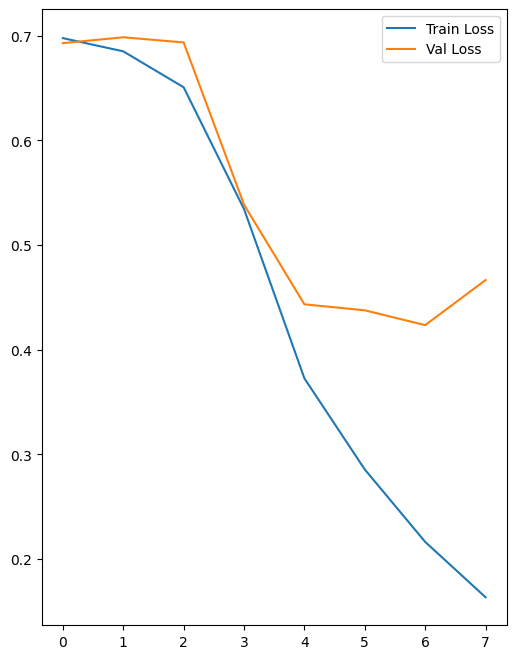

In [21]:
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

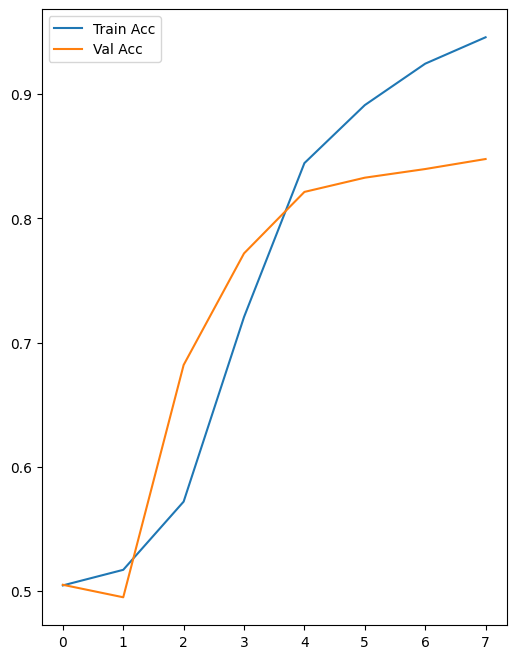

In [22]:
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()